# Introduction

This notebook aims at discovering Convolutional Neural Network. We will see the theory behind it, and an implementation in Pytorch for hand-digits classification on MNIST dataset. 

# History

Contrary to what most people think, Neural Networks is quite an old concept. It was first introduced in 1957 under the name ***perceptron***. Peceptron is a 1-layer feed forward neural network. However the infrastructure and the algorthm around it was not good enough to allow large scale training. Later on in 1986, ***Multi Layer Perceptron (MLP)*** was introduced with the backpropagation algorithm in order to train a network with more than 1 layer. Thanks to this algorithm we are not able to train non-linear model which can learn high level abstract features. Then ***Convolutional Neural Network (CNN)*** has been introduced in order to learn better features and with the possibility to reduce the number of parameters to be trained. And now, here we are, in the ***Deep Learning era*** 

    # Multi-Layer Perceptron

The first thing to ask is : why do we needed Convolutional Neural Network in the first place... Well, let's see what happen when we train a Multi-Layer Perceptron to recognize hand-written digits. In Machine Learning we have our own "Hello World" which is the MNIST dataset. Let's see what this dataset is about and how a multi-layer perceptron will perform.   

In [1]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from pathlib import Path

In [2]:
data = np.load('Data/data_train.npy').T
X_og = data.copy()
#X_og= data.copy()/255
y_og =np.load('Data/labels_corrected.npy')

In [3]:
print(X_og)

[[161 162 162 ... 149 149 147]
 [162 162 162 ... 165 165 165]
 [195 195 195 ... 191 191 191]
 ...
 [195 195 195 ... 195 195 195]
 [158 157 157 ... 141 140 141]
 [149 149 150 ... 138 142 147]]


In [4]:
y = y_og.astype(int)
print(y)

[8 8 1 ... 1 3 3]


In [5]:
print(np.shape(X_og))
print(np.shape(y))

(6720, 90000)
(6720,)


In [6]:
#X = 1-X_og.copy()
def resize_func(input_data,new_width,new_height):#input the (1,90000) data
    size1 = np.shape(input_data)[0]
    size2 = int(size1**(0.5))
    output = cv2.resize(input_data.reshape(size2,size2),(new_width,new_height))
    return output


def morph_ops(input_data,n_width,n_height): # morphological operations 
    dilate_kernel = np.ones((2,2),np.uint8)
    x0 = 1-input_data
    x0_1 = resize_func(x0,n_width,n_height)
    x1 = x0_1.reshape(n_width,n_height)
    x4 = np.clip(x1-np.mean(x1),0,1)
    x5 = np.where(x1 < 0.35,0,x4)
    x6 = cv2.dilate(x5,dilate_kernel,iterations=1)
    x7 = np.where(x6<0.15,0,x6)
    x8 = normalize(x7.reshape(-1,1)).reshape(n_width,n_height)
    x9 = np.where(x8>0.3,1,x8)
    x10 = x9.reshape(1,-1)
    picture = x10
    return picture # 1, n_width*n_height


In [7]:
def morph_trans(input_data,n_width, n_height):
    #image_low=resize_func(input_data,n_width,n_height)

    image_gray=cv2.bitwise_not(input_data)
    
    ret,image_bw = cv2.threshold(image_gray,170,255,cv2.THRESH_BINARY)

    #image_bw=cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, \
    #                              cv2.THRESH_BINARY,20,-2)
    
    # create horizontal and vertical line 
    horizontal = np.copy(image_bw)
    vertical = np.copy(image_bw)
    # specify horizontal axis
    cols = horizontal.shape[1]
    hor_size = cols//8
    
    # create structural element
    horizontal_struc =cv2.getStructuringElement(cv2.MORPH_RECT,
                                                (hor_size,1))
    horizontal =cv2.erode(horizontal,horizontal_struc, iterations=1)
    horizontal = cv2.dilate(horizontal,horizontal_struc,iterations=1)
    
    # remove horizontal 
    cnts = cv2.findContours(horizontal,cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts)==2 else cnts[1]
    
    
    """
    # specify vertical 
    rows = vertical.shape[0]
    ver_size = rows//36
    
    # create vertical structural element 
    vertical_struc = cv2.getStructuringElement(cv2.MORPH_RECT,(1,ver_size))
    vertical =cv2.erode(vertical,vertical_struc)
    vertical =cv2.dilate(vertical,vertical_struc)
    """
    dilate_kernel = np.ones((6,1),np.uint8) 
    result=cv2.morphologyEx(image_bw,cv2.MORPH_OPEN,
                                dilate_kernel,iterations=2)

    
    pic_dilate= cv2.dilate(image_bw, dilate_kernel, iterations=1)
    #pic_dilate=cv2.erode(pic_dilate,dilate_kernel,iterations=2)
    image_out=horizontal
    return image_out

In [15]:

##parameters 
# size after resize the original image 
n_width  = 64
n_height = 64

# split data
test_data_size=0.2

#batch and Epoch 
BATCH_SIZE =200
Epoch = 500 


# number of hidden layers 
h_layer_1 = 500 # hidden layer 1
h_layer_2 = 100 # hidden layer 2
h_layer_3 = 10  # hidden layer 3

# learning rate 
learn_rate = 0.005

# cnn kernel size 
kernel1 =2
kernel2 =3
kernel3 =5

max_pool_kernel=2
# convolution 1
ch1_in=1
ch1_out=16 
stride1=1
padding1=2

#convolution 2
ch2_in=ch1_out
ch2_out= 32
stride2=1
padding2=2

#convolution 3
ch3_in=ch2_out
ch3_out= 64
stride3=1
padding3=2

#linear 1
out_layer_size = 8*8
linear1_in =out_layer_size*ch3_out
linear1_out = 128

#linear 2
out_class =10
linear2_in = linear1_out

#dropout 
prob=0.2


directory='Output_model/'
filename ='CNN_'+'C_level1_'+'lr0_001'+'Ep_'+str(Epoch)+'B'+str(BATCH_SIZE)

In [16]:
X_new = np.zeros((np.shape(X_og)[0],n_width*n_height))

for ii in range(np.shape(X_new)[0]):
    newrow = morph_ops(X_og[ii,:],n_width,n_height)
    newrow = newrow.reshape(1,-1)
    newrow = resize_func(newrow[0,:],n_width,n_height)
    newrow = newrow.reshape(1,-1)
    X_new[ii,:] = newrow
X = X_new

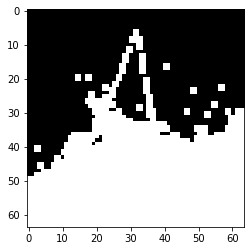

In [17]:
index = 391
'''
fig=plt.figure(figsize=(20,10))

for ii in range(index):
    fig.add
'''
x1 = X[index,:].reshape(n_width,n_height)
plt.imshow(x1,cmap='gray')

In [456]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_data_size)

In [ ]:

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)


In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(n_width*n_height,h_layer_1)
        self.linear2 = nn.Linear(h_layer_1,h_layer_2)
        self.linear3 = nn.Linear(h_layer_2,out_class)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)
 
mlp = MLP()
print(mlp)


In [ ]:
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters(),lr=learn_rate)#,lr=0.001, betas=(0.9,0.999))
    error = nn.CrossEntropyLoss()
    EPOCHS = Epoch
    model.train()
    lossvec = []
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            lossvec.append(loss.item())
            optimizer.step()

            # Total correct predictions
            #predicted = torch.max(output.data,0)[1]
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            #print(correct)
            if batch_idx % 100 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item(), float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
    return lossvec
                

In [ ]:
loss_vec = fit(mlp, train_loader)

In [ ]:
plt.figure()
plt.plot(loss_vec)
plt.show()

## MLP Evaluation

In [ ]:
def evaluate(model):
#model = mlp
    predict_list = []
    correct = 0 
    for test_imgs, test_labels in test_loader:
        #print(test_imgs.shape)
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        predict_list.append(predicted)
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct)*100 / (len(test_loader)*BATCH_SIZE)))
predict = evaluate(mlp)

<center><h2>Convolutional Neural Network</h2></center>

## Explanation

To better understand convolutional neural network I recommend the great section on it here : http://cs231n.github.io/convolutional-networks/

**Convolutional operation** : First let's clarify briefly how we can perform the convolutional operation on an image. For that we need to define a **kernel** which is a small matrix of size 5 \* 5 for example. To perform the convolution operation, we just need to slide the kernel along the image horizontally and vertically and do the dot product of the kernel and the small portion of the image.

**Pooling** : the convolutional operation give an output of the same size of the input image. To reduce the size of the image and thus reduce the number of paramers in the model we perform a Pooling operation. The pooling operation need a window size.. By sliding the window along the image, we compute the mean or the max of the portion of the image inside the window in case of MeanPooling or MaxPooling.

**Stride** is the number of pixels to pass at a time when sliding the convolutional kernel.  

**Padding** to preserve exactly the size of the input image, it is useful to add a zero padding on the border of the image. 


**To remember** : What makes a CNN so interesting for images is that it is invariant by translation and for each convolutional layer we only need to store the kernels. Thus we can stack a lot of layers to learn deep features without having too much parameters that would make a model untrainnable. 

## Data loader

Since a CNN needs a image shape as input let's reshape our flatten images to real image

In [ ]:
torch_X_train = torch_X_train.view(-1, 1,n_width,n_height).float()
torch_X_test = torch_X_test.view(-1,1,n_width,n_height).float()
print(torch_X_train.shape)
print(torch_X_test.shape)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)


In [ ]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(ch1_in, ch1_out, 
                               kernel_size=kernel1, 
                               stride=stride1,
                              padding = padding1)
        self.conv2 = nn.Conv2d(ch2_in, ch2_out, 
                               kernel_size=kernel2,
                              stride = stride2,
                              padding = padding2)
        self.conv3 = nn.Conv2d(ch3_in, ch3_out, 
                               kernel_size=kernel3,
                              stride =stride3,
                              padding= padding3)
        self.fc1 = nn.Linear(linear1_in,linear1_out)
        self.fc2 =nn.Linear(linear2_in,out_class)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size=max_pool_kernel))
        #x = F.dropout(x, p=prob, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=max_pool_kernel))
        #x = F.dropout(x, p=prob, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),kernel_size=max_pool_kernel))
        #x = F.dropout(x, p=prob, training=self.training)
        x = x.view(x.size(0),-1)#linear1_in)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    

In [ ]:
    

class CNN_TA(nn.Module):
    def __init__(self):
        super(CNN_TA, self).__init__()
        self.conv1 = nn.Sequential(               # input shape (1, n_width, n_height)
            nn.Conv2d(
                in_channels=ch1_in,               # input height
                out_channels=ch1_out,             # n_filters
                kernel_size=kernel1,              # filter size
                stride=stride1,                   # filter movement/step
                padding=padding1,                 # padding
            ),                                    # output shape (16, n_width, n_height)
            nn.ReLU(),                            # activation
            nn.MaxPool2d(kernel_size=max_pool_kernel),    # choose max value in 2x2 area, output shape (16, n_width/kernel, n_height/kernel)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(ch2_in, ch2_out, kernel2, stride2, padding2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=max_pool_kernel),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(linear1_in, out_class)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (BATCH_SIZE, 32 * 7 * 7)
        output = self.out(x)
        return output, x


 


In [ ]:
cnn = CNN()
#cnn = CNN_TA()
print(cnn)

it = iter(train_loader)
X_batch, y_batch = next(it)
print(X_batch.shape)
print(cnn.forward(X_batch).shape)

In [ ]:
fit(cnn,train_loader)

In [ ]:
evaluate(cnn)

In [ ]:
output = cnn.forward(X_batch)
#predicted = torch.max(output.data,1)[1]
predicted = torch.max(output,1)[1].data.numpy()
print(X_batch.shape)
print(output.shape)
print('Predicted number :',predicted[:10])
print('Real Number :',y_batch[:10])

In [ ]:
# save current model in an hdf5 file
f_directory=directory+filename
f_name=filename+'.hdf5'
model_dir = Path(f_directory)
model_dir.mkdir(parents = True, exist_ok = True)
torch.save(cnn.state_dict(), model_dir.joinpath(f_name))



# Uncomment the following line to load and print the saved model
# model = torch.load(model_dir.joinpath('cnn_pytorch.hdf5'))
# print(model)
# Also visit https://pytorch.org/tutorials/beginner/saving_loading_models.html 
# for more details about saving and loading models in PyTorch.


